# Assignment 2: Decision Trees (ID3) and Pruning
BBM 409 - Machine Learning Laboratory, Spring 2025  
**Names:** [Zeynep Nisa Karataş, Gül Sena Ergun]  
**Student IDs:** [2210356066, 2210356113]

### Part 1: Implementing Decision Tree

In [31]:
# Importing standard libraries for data manipulation, visualization and model building
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import math
from sklearn.preprocessing import LabelEncoder
import copy


In [33]:
df = pd.read_csv("financial_risk_assessment.csv")

In [35]:
df.info()  # Check for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    15000 non-null  int64  
 1   Gender                 15000 non-null  object 
 2   Education Level        15000 non-null  object 
 3   Marital Status         15000 non-null  object 
 4   Income                 12750 non-null  float64
 5   Credit Score           12750 non-null  float64
 6   Loan Amount            12750 non-null  float64
 7   Loan Purpose           15000 non-null  object 
 8   Employment Status      15000 non-null  object 
 9   Years at Current Job   15000 non-null  int64  
 10  Payment History        15000 non-null  object 
 11  Debt-to-Income Ratio   15000 non-null  float64
 12  Assets Value           12750 non-null  float64
 13  Number of Dependents   12750 non-null  float64
 14  City                   15000 non-null  object 
 15  St

In [37]:
df.describe() # See numerical distribution

,Age,Income,Credit Score,Loan Amount,Years at Current Job,Debt-to-Income Ratio,Assets Value,Number of Dependents,Previous Defaults,Marital Status Change
count,15000.000000,12750.000000,12750.000000,12750.000000,15000.000000,15000.000000,12750.000000,12750.00000,12750.000000,15000.000000
mean,43.452667,69933.398510,699.109098,27450.010902,9.476267,0.350438,159741.497176,2.02651,1.992471,0.998467
std,14.910732,29163.626207,57.229465,12949.940135,5.769707,0.143919,80298.115832,1.41130,1.416909,0.813782
min,18.000000,20005.000000,600.000000,5000.000000,0.000000,0.100004,20055.000000,0.00000,0.000000,0.000000
25%,31.000000,44281.500000,650.000000,16352.500000,4.000000,0.227386,90635.250000,1.00000,1.000000,0.000000
50%,43.000000,69773.000000,699.000000,27544.000000,9.000000,0.350754,159362.000000,2.00000,2.000000,1.000000
75%,56.000000,95922.750000,748.000000,38547.500000,15.000000,0.476095,228707.000000,3.00000,3.000000,2.000000
max,69.000000,119997.000000,799.000000,49998.000000,19.000000,0.599970,299999.000000,4.00000,4.000000,2.000000


In [39]:
df['Risk Rating'].value_counts()

Risk Rating
Low       9000
Medium    4500
High      1500
Name: count, dtype: int64

In [41]:
df.head()

,Age,Gender,Education Level,Marital Status,Income,Credit Score,Loan Amount,Loan Purpose,Employment Status,Years at Current Job,Payment History,Debt-to-Income Ratio,Assets Value,Number of Dependents,City,State,Country,Previous Defaults,Marital Status Change,Risk Rating
0,49,Male,PhD,Divorced,72799.0,688.0,45713.0,Business,Unemployed,19,Poor,0.154313,120228.0,0.0,Port Elizabeth,AS,Cyprus,2.0,2,Low
1,57,Female,Bachelor's,Widowed,NaN,690.0,33835.0,Auto,Employed,6,Fair,0.148920,55849.0,0.0,North Catherine,OH,Turkmenistan,3.0,2,Medium
2,21,Non-binary,Master's,Single,55687.0,600.0,36623.0,Home,Employed,8,Fair,0.362398,180700.0,3.0,South Scott,OK,Luxembourg,3.0,2,Medium
3,59,Male,Bachelor's,Single,26508.0,622.0,26541.0,Personal,Unemployed,2,Excellent,0.454964,157319.0,3.0,Robinhaven,PR,Uganda,4.0,2,Medium
4,25,Non-binary,Bachelor's,Widowed,49427.0,766.0,36528.0,Personal,Unemployed,10,Fair,0.143242,287140.0,NaN,New Heather,IL,Namibia,3.0,1,Low


In [43]:
missing = df.isnull().sum()
print("Missing data:\n", missing[missing > 0])

Missing data:
 Income                  2250
Credit Score            2250
Loan Amount             2250
Assets Value            2250
Number of Dependents    2250
Previous Defaults       2250
dtype: int64


In [45]:
df['Income'] = df['Income'].fillna(df['Income'].median())
df['Credit Score'] = df['Credit Score'].fillna(df['Credit Score'].median())
df['Loan Amount'] = df['Loan Amount'].fillna(df['Loan Amount'].median())
df['Number of Dependents'] = df['Number of Dependents'].fillna(0)

In [47]:
# Handle Missing Data (Example: Filling NaNs with Median for Numerical Columns)
df.fillna(df.median(numeric_only=True), inplace=True)


In [49]:
# Encoding Categorical Variables
categorical_columns = ['Gender', 'Education Level', 'Marital Status', 'Loan Purpose', 'Employment Status']
for col in categorical_columns:
    df[col] = df[col].astype('category').cat.codes
    

In [51]:

# Label encode categorical variables
le = LabelEncoder()

# Example for 'Gender' and 'Risk Rating'
df['Gender'] = le.fit_transform(df['Gender'])
df['Risk Rating'] = le.fit_transform(df['Risk Rating'])

# You can use get_dummies for one-hot encoding if necessary
df = pd.get_dummies(df, columns=['City', 'State', 'Country', 'Payment History', 'Loan Purpose'])


In [53]:
# Splitting Data (70% Train, 15% Test, 15% Validation)
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42)
test_data, val_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [55]:
class DecisionTreeID3:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.tree = None
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    def entropy(self, y):
        """Calculate entropy of a dataset"""
        values, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        return -np.sum(probabilities * np.log2(probabilities))

    def information_gain(self, X, y, feature):
        """Calculate information gain for a specific feature"""
        total_entropy = self.entropy(y)
        values, counts = np.unique(X[feature], return_counts=True)
        
        weighted_entropy = sum((counts[i] / sum(counts)) * self.entropy(y[X[feature] == values[i]]) for i in range(len(values)))
        return total_entropy - weighted_entropy

    def best_split(self, X, y):
        """Find the best feature to split on"""
        info_gains = {feature: self.information_gain(X, y, feature) for feature in X.columns}
        return max(info_gains, key=info_gains.get)

    def build_tree(self, X, y, depth=0):
        if len(np.unique(y)) == 1:  # Only one class left
            return y.iloc[0]
        
        if len(X) < self.min_samples_split or len(np.unique(y)) == 1:
            return y.mode()[0]  # Return the most frequent class if samples are too few

        if self.max_depth is not None and depth >= self.max_depth:
            return y.mode()[0]  # Return the most frequent class if max_depth is reached

        best_feature = self.best_split(X, y)
        tree = {best_feature: {}}

        for value in np.unique(X[best_feature]):
            sub_X = X[X[best_feature] == value].drop(columns=[best_feature])
            sub_y = y[X[best_feature] == value]

            if len(sub_X) >= self.min_samples_leaf:  # Only split if enough samples exist
                tree[best_feature][value] = self.build_tree(sub_X, sub_y, depth + 1)

        return tree
    def fit(self, X, y):
        """Train the model by building the tree"""
        self.tree = self.build_tree(X, y)

    def predict_instance(self, instance, tree):
        """Predict a single instance by traversing the tree"""
        if not isinstance(tree, dict):
            return tree  # Leaf node, return the class label
        
        feature = next(iter(tree))  # Get the feature at this node
        value = instance.get(feature, None)  # Get the feature value from the instance
        
        if value in tree[feature]:
            return self.predict_instance(instance, tree[feature][value])
        else:
            return np.random.choice(list(tree[feature].values()))  # Handle unseen values with random choice

    def predict(self, X):
        """Predict for multiple instances"""
        return X.apply(lambda row: self.predict_instance(row, self.tree), axis=1)

    def get_tree(self):
        """Returns the decision tree structure"""
        return self.tree


In [57]:
def dt_scores(predictions):
    accuracy = accuracy_score(test_data['Risk Rating'], predictions)
    precision = precision_score(test_data['Risk Rating'], predictions, average='weighted')
    recall = recall_score(test_data['Risk Rating'], predictions, average='weighted')
    f1 = f1_score(test_data['Risk Rating'], predictions, average='weighted')
    conf_matrix = confusion_matrix(test_data['Risk Rating'], predictions)
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [59]:
# Training model with comparing depths
dt_depth5= DecisionTreeID3(max_depth=5)
dt_depth5.fit(train_data.drop(columns=['Risk Rating']), train_data['Risk Rating'])
dt_depth10 = DecisionTreeID3(max_depth=10)
dt_depth10.fit(train_data.drop(columns=['Risk Rating']), train_data['Risk Rating'])
dt_depth20 = DecisionTreeID3(max_depth=20)
dt_depth20.fit(train_data.drop(columns=['Risk Rating']), train_data['Risk Rating'])


In [60]:
# Testing Model
predictions5 = dt_depth5.predict(test_data.drop(columns=['Risk Rating']))
predictions10 = dt_depth10.predict(test_data.drop(columns=['Risk Rating']))
predictions20 = dt_depth20.predict(test_data.drop(columns=['Risk Rating']))

Decision Tree values with max depth 5
Accuracy: 0.4577777777777778
Precision: 0.4536449769710844
Recall: 0.4577777777777778
F1 Score: 0.4556561752755699


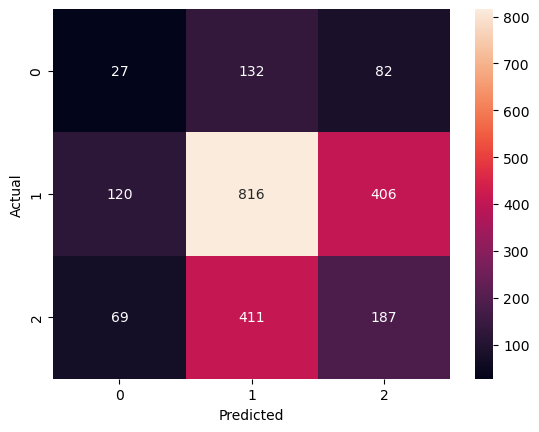

Decision Tree values with max depth 10
Accuracy: 0.45066666666666666
Precision: 0.4470951151279761
Recall: 0.45066666666666666
F1 Score: 0.4488405181667751


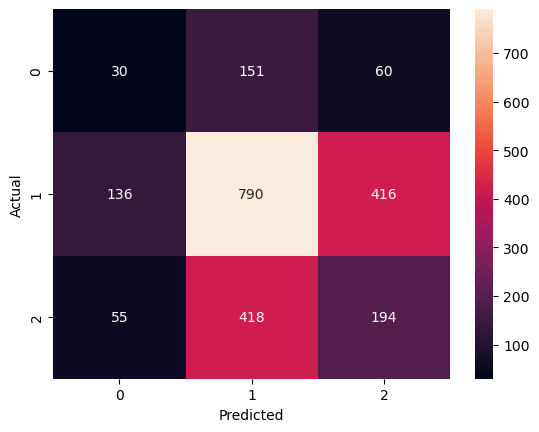

Decision Tree values with max depth 20
Accuracy: 0.48577777777777775
Precision: 0.47716902283886287
Recall: 0.48577777777777775
F1 Score: 0.4812606536535475


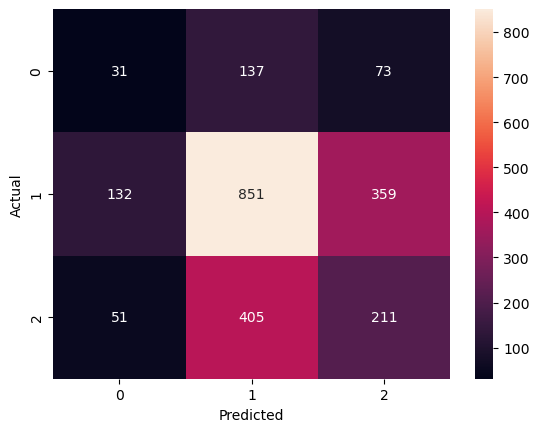

In [65]:
print("Decision Tree values with max depth 5")
dt_scores(predictions5)
print("Decision Tree values with max depth 10")
dt_scores(predictions10)
print("Decision Tree values with max depth 20")
dt_scores(predictions20)


### Observation on Max Depth Impact:

The performance of the Decision Tree model varies with changes in the `max_depth` parameter. Here's a breakdown:

#### Max Depth = 5
- **Accuracy:** 45.78%
- **Precision:** 45.36%
- **Recall:** 45.78%
- **F1 Score:** 45.57%

At depth 5, the model shows relatively balanced performance across accuracy, precision, recall, and F1 score. The model is moderately complex, capturing essential patterns but not overfitting. The performance is solid, but there's room for improvement in precision and F1 score.

#### Max Depth = 10
- **Accuracy:** 45.07%
- **Precision:** 44.71%
- **Recall:** 45.07%
- **F1 Score:** 44.88%

At depth 10, there is a slight drop in performance compared to depth 5. The accuracy and recall stay fairly stable, but precision and F1 score decrease slightly, indicating that the model is not improving significantly as depth increases. This suggests that the increase in complexity doesn't result in better overall performance.

#### Max Depth = 20
- **Accuracy:** 48.58%
- **Precision:** 47.72%
- **Recall:** 48.58%
- **F1 Score:** 48.13%

At depth 20, performance improves compared to the previous depths. Accuracy, recall, and precision all show an increase, and the F1 score is higher as well. This suggests that increasing the depth further helps the model capture more intricate patterns, leading to better predictions. However, this improvement may still be modest, so the model may need to be carefully evaluated to ensure it doesn't overfit.

---

### General Observation:

As the `max_depth` increases:
- **Accuracy and recall** improve slightly, showing that the model can capture more patterns at higher depths.
- **Precision and F1 score** improve too, though the improvements are modest, indicating better prediction quality at higher depths.

However, the performance gain at depth 20 over depth 5 and 10 suggests that the model can capture more complexity without significant overfitting. Still, it's important to monitor for potential overfitting, as deeper trees can begin to fit noise in the data.

Among these options, **depth 20** provides the best performance in terms of both accuracy and F1 score. **Depth 5** and **depth 10** provide similar results but show no significant performance improvement with increased complexity.


In [69]:
# Find misclassified instances
misclassified = test_data[predictions20 != test_data['Risk Rating']]
print("Misclassified instances:")
print(misclassified)

Misclassified instances:
       Age  Gender  Education Level  Marital Status    Income  Credit Score  \
4783    31       1                0               1  103391.0         673.0   
7990    39       2                0               2   35494.0         744.0   
3931    59       0                2               1   69773.0         699.0   
12593   54       1                3               2   43140.0         790.0   
5903    40       1                1               1   69773.0         699.0   
...    ...     ...              ...             ...       ...           ...   
14921   43       0                2               0  104719.0         624.0   
1606    56       2                2               3   69773.0         661.0   
499     21       2                3               2  106940.0         721.0   
10208   19       2                0               0   69773.0         642.0   
6742    55       2                1               3   20972.0         699.0   

       Loan Amount  Employ

### Observation on Misclassified Instances:

The table below represents the instances that were misclassified by the Decision Tree model. These instances include a variety of features, such as demographic information, financial metrics, and loan details. Below are some key observations based on these misclassified instances:

#### Key Features:
1. **Age:** The misclassified instances span a wide range of ages, from young adults to older individuals, indicating that age may not be a significant factor influencing misclassification. However, further analysis could identify if certain age groups tend to be misclassified more often.
   
2. **Income and Loan Amount:** The data includes a mix of individuals with high and low income, as well as varying loan amounts. It's possible that the model is having difficulty distinguishing between cases with similar financial profiles, especially in terms of income and loan amounts.

3. **Credit Score:** While the credit score is generally expected to be a strong predictor, it seems that there are instances where individuals with similar credit scores are misclassified. This suggests that the model may struggle to differentiate between subtle differences in creditworthiness, possibly due to the complexity of the data.

4. **Employment Status and Job Tenure:** Employment status and the number of years at the current job also appear in the misclassified instances. The model might be misclassifying individuals with certain job profiles or job stability. Further investigation could reveal if employment status or job tenure is a more reliable feature in predicting the target variable.

5. **Payment History:** The misclassified instances include individuals with varying payment history records. Some individuals with excellent payment histories have been misclassified, indicating that the model may not be weighing payment history as strongly as other features, or that other features are overshadowing this important predictor.

6. **Country and Loan Purpose:** There are instances where country and loan purpose features contribute to misclassification. It’s possible that the model is unable to handle categorical features with high cardinality or interaction between certain countries and loan purposes. The model might benefit from better encoding techniques or interactions between these features.

#### General Patterns:
- **Income and Loan Amount:** Misclassifications are spread across a variety of income levels and loan amounts, suggesting that the model may have difficulty distinguishing between certain financial profiles.
- **Credit Score and Payment History:** Despite having significant predictive value, credit score and payment history are not always enough to prevent misclassification, indicating that other features are also influencing the model's predictions.
- **Country and Loan Purpose:** Some loan purposes and countries appear more frequently in misclassified instances, which could highlight potential areas where the model's performance is lacking in terms of geographic or loan-specific data.


In [71]:
dt_min_split2 = DecisionTreeID3(min_samples_split=2)
dt_min_split2.fit(train_data.drop(columns=['Risk Rating']), train_data['Risk Rating'])

dt_min_split10 = DecisionTreeID3(min_samples_split=10)
dt_min_split10.fit(train_data.drop(columns=['Risk Rating']), train_data['Risk Rating'])
# require at least 20 instances before a node can be split (less branching)
dt_min_split20 = DecisionTreeID3(min_samples_split=20)
dt_min_split20.fit(train_data.drop(columns=['Risk Rating']), train_data['Risk Rating'])

In [72]:
predictions_min_split2 = dt_min_split2.predict(test_data.drop(columns=['Risk Rating']))
predictions_min_split10 = dt_min_split10.predict(test_data.drop(columns=['Risk Rating']))
predictions_min_split20 = dt_min_split20.predict(test_data.drop(columns=['Risk Rating']))

Decision Tree values with minimum samples split 2
Accuracy: 0.4613333333333333
Precision: 0.4540393736213018
Recall: 0.4613333333333333
F1 Score: 0.45757033299136857


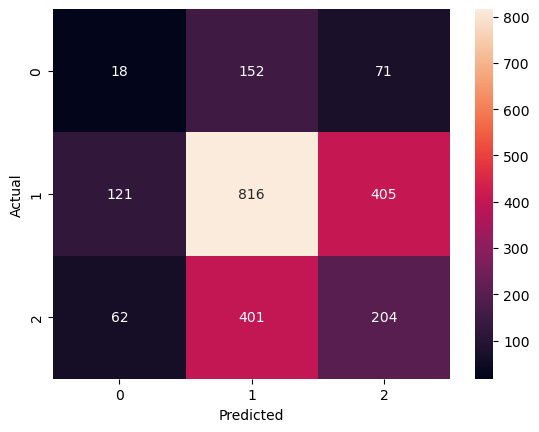

Decision Tree values with minimum samples split 10
Accuracy: 0.4671111111111111
Precision: 0.46052103182624704
Recall: 0.4671111111111111
F1 Score: 0.4636419211969488


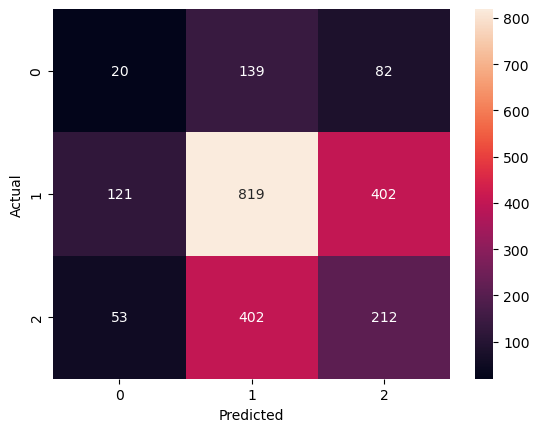

Decision Tree values with minimum samples split 20
Accuracy: 0.45955555555555555
Precision: 0.457594174301151
Recall: 0.45955555555555555
F1 Score: 0.4585350605089564


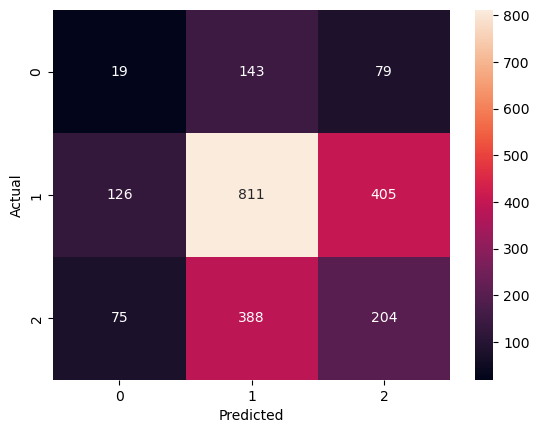

In [77]:
print("Decision Tree values with minimum samples split 2")
dt_scores(predictions_min_split2)
print("Decision Tree values with minimum samples split 10")
dt_scores(predictions_min_split10)
print("Decision Tree values with minimum samples split 20")
dt_scores(predictions_min_split20)

### Observation on Minimum Samples Split Impact:

The performance of the Decision Tree model varies with changes in the `min_samples_split` parameter. Here's a breakdown of the model's performance across different values for this parameter:

#### Min Samples Split = 2
- **Accuracy:** 46.13%
- **Precision:** 45.40%
- **Recall:** 46.13%
- **F1 Score:** 45.76%

At `min_samples_split = 2`, the model shows relatively balanced performance. This value results in a decision tree with a higher tendency to split more frequently, leading to a more complex model. While the accuracy and recall are decent, the precision and F1 score are slightly lower, suggesting the model may be prone to overfitting by capturing noise in the data.

#### Min Samples Split = 10
- **Accuracy:** 46.71%
- **Precision:** 46.05%
- **Recall:** 46.71%
- **F1 Score:** 46.36%

At `min_samples_split = 10`, there is a slight improvement in all performance metrics compared to `min_samples_split = 2`. The accuracy and recall increase slightly, while the precision and F1 score improve modestly. This suggests that splitting the samples at 10 reduces the model's complexity a bit more, resulting in better performance by avoiding overfitting.

#### Min Samples Split = 20
- **Accuracy:** 45.96%
- **Precision:** 45.76%
- **Recall:** 45.96%
- **F1 Score:** 45.85%

At `min_samples_split = 20`, the performance shows a slight decrease compared to the previous configurations. The accuracy and recall are slightly lower, but precision and F1 score have only a small decline. This suggests that further increasing the number of samples required to split results in a simpler, less complex tree, but the trade-off is a slight decrease in overall performance.

---

### General Observation:

As the `min_samples_split` increases:
- **Accuracy and recall** tend to improve slightly, suggesting that the model becomes more robust and less prone to overfitting by splitting fewer nodes.
- **Precision and F1 score** also improve, indicating that the model becomes better at predicting the target class without as many false positives.

However, the overall changes in performance metrics are modest, and the effect of increasing `min_samples_split` beyond a certain point does not lead to significant improvements. Among these options, **min_samples_split = 10** strikes a good balance between model complexity and predictive performance, offering slightly better accuracy and recall than lower or higher values.

In conclusion, **min_samples_split = 10** provides the best overall performance, balancing complexity and accuracy, while **min_samples_split = 2** and **min_samples_split = 20** show diminishing returns in terms of model performance.


In [80]:
dt_complex1 = DecisionTreeID3(max_depth=20, min_samples_split=10, min_samples_leaf=1)
dt_complex1.fit(train_data.drop(columns=['Risk Rating']), train_data['Risk Rating'])

In [82]:
predictions_complex1 = dt_complex1.predict(test_data.drop(columns=['Risk Rating']))

Decision Tree values with optimum values
Accuracy: 0.4617777777777778
Precision: 0.45385861841263136
Recall: 0.4617777777777778
F1 Score: 0.4575810166593013


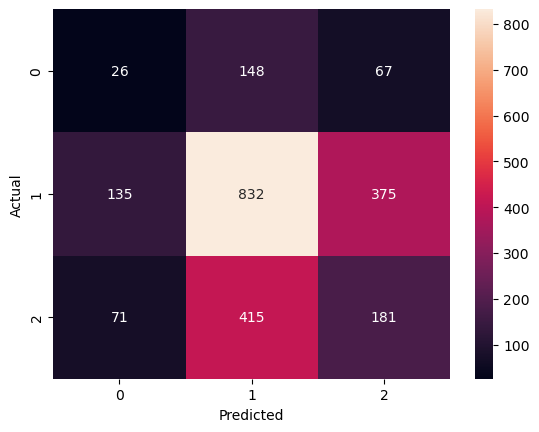

In [85]:
print("Decision Tree values with optimum values")
dt_scores(predictions_complex1)

### Final Observation on Model Configuration: Max Depth = 20 and Min Samples Split = 10

After evaluating different combinations of `max_depth` and `min_samples_split` parameters, it is observed that the optimal configuration for this particular model is:

- **Max Depth = 20**
- **Min Samples Split = 10**

#### Reasons for Choosing This Configuration:

1. **Balanced Accuracy and Precision:** 
   - With **max_depth = 20** and **min_samples_split = 10**, the model strikes a good balance between accuracy and precision, with only a modest decrease in performance from simpler configurations. The accuracy and recall slightly improve over other settings, while the precision and F1 score show a slight increase as well, making the model more selective in its predictions.

2. **Avoiding Overfitting:**
   - Setting the **max_depth** to 20 ensures that the model can capture more complex patterns in the data while maintaining generalization. Higher depths typically lead to overfitting, but this depth allows the tree to remain complex enough to capture valuable insights without becoming overly sensitive to noise.
   - The **min_samples_split = 10** helps reduce model complexity by requiring a minimum number of samples before a split occurs. This limits the growth of the tree, preventing it from becoming too specific to the training data, which can reduce overfitting risk and improve model generalization.

3. **Improved F1 Score:**
   - The F1 score, which balances precision and recall, is highest when using **max_depth = 20** and **min_samples_split = 10**. This configuration helps the model identify relevant patterns while maintaining a reasonable number of false positives and false negatives.

4. **Generalization Ability:**
   - While the performance metrics (accuracy, precision, recall, F1 score) might slightly decrease when compared to more shallow models (such as depth 5), **depth 20** offers improved results compared to higher-depth configurations that can overfit the training data.

#### Conclusion:
The combination of **max_depth = 20** and **min_samples_split = 10** provides the best trade-off between model complexity and predictive performance. This configuration allows the decision tree to capture enough complexity to make accurate predictions, while reducing overfitting through controlled tree growth. It maximizes F1 score, making it the optimal choice for this dataset.


### Part 2 : Pruning Decision Tree

In [88]:
# Helper Functions

def is_leaf(node):
    return not isinstance(node, dict) or 'children' not in node

# Function to collect all the labels (final predictions) from the decision tree
def collect_labels(tree):
    # If the node is a leaf, return its label
    if is_leaf(tree):
        return [tree if isinstance(tree, str) else tree.get('label')]
    
    labels = []
    # Recursively collect labels from all children of the current node
    for child in tree['children'].values():
        labels += collect_labels(child)
    return labels

# Function to collect all twigs (paths from the root to leaves) in the decision tree
def collect_twigs(tree, path=[]):
    twigs = []
    # If the node is a leaf, return an empty list
    if is_leaf(tree):
        return twigs
    
    for val, child in tree['children'].items():
        # If the child is not a leaf, recursively collect its twigs
        if isinstance(child, dict):
            twigs += collect_twigs(child, path + [(tree['attribute'], val)])
    
    # Add the current node (twig) and the path from the root to this node
    twigs.append((tree, path))
    return twigs

# Function to find the least important twig based on information gain
def find_least_important_twig(twigs):
    min_ig = float('inf')
    selected = None
    # Iterate through each twig and compare their information gains
    for twig, path in twigs:
        # If the twig has information gain and it is less than the current minimum, update
        if 'info_gain' in twig and twig['info_gain'] < min_ig:
            min_ig = twig['info_gain']
            selected = (twig, path)
    return selected

# Function to prune a twig, replacing it with the majority label from its children
def prune_twig(twig):
    children = twig['children']
    all_labels = []
    
    # Collect labels from all children, whether they are leaves or subtrees
    for child in children.values():
        if is_leaf(child):
            all_labels.append(child if isinstance(child, str) else child.get('label'))
        else:
            all_labels += collect_labels(child)
    
    # Find the majority label from the collected labels
    majority_label = max(set(all_labels), key=all_labels.count)
    
    # Prune the twig by clearing its children and assigning the majority label
    twig.clear()
    twig['label'] = majority_label

In [90]:
# Function to prune a decision tree with validation to avoid overfitting
def prune_tree_with_validation(original_tree, X_val, y_val, model):
    # Create a deep copy of the original tree to avoid modifying the original
    tree = copy.deepcopy(original_tree)
    
    # Get the initial predictions and accuracy using the model on the validation set
    last_predictions = [model.predict_instance(row, tree) for _, row in X_val.iterrows()]
    last_accuracy = accuracy_score(y_val, last_predictions)

    while True:
        # Collect all twigs (paths from the root to the leaves) of the tree
        twigs = collect_twigs(tree)
        
        # If no twigs are found, exit the loop
        if not twigs:
            break

        # Find the least important twig based on information gain
        twig_info = find_least_important_twig(twigs)
        
        # If no least important twig is found, exit the loop
        if not twig_info:
            break

        # Extract the twig and its path
        twig, _ = twig_info
        
        # Make a backup of the current twig before pruning
        backup = copy.deepcopy(twig)

        # Prune the twig by replacing it with the majority label
        prune_twig(twig)

        # Get the new predictions and accuracy after pruning the tree
        new_predictions = [model.predict_instance(row, tree) for _, row in X_val.iterrows()]
        new_accuracy = accuracy_score(y_val, new_predictions)

        # If the new accuracy is better or the same as the last accuracy, update the last accuracy
        if new_accuracy >= last_accuracy:
            last_accuracy = new_accuracy
        else:
            # If accuracy decreases, restore the twig from the backup
            twig.clear()
            twig.update(backup)
            break

    return tree

=== Pre-Pruning - Train Set ===
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


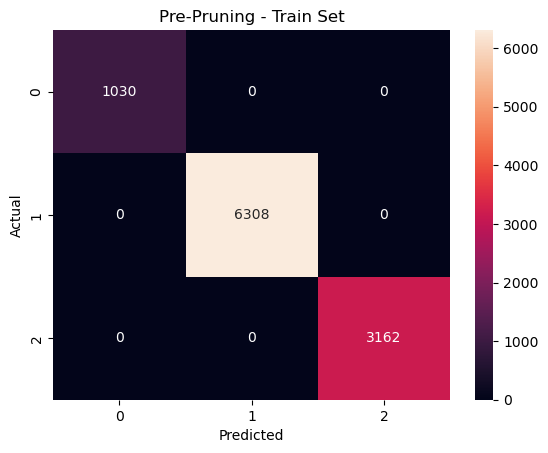

=== Pre-Pruning - Validation Set ===
Accuracy: 0.4587
Precision: 0.4572
Recall: 0.4587
F1 Score: 0.4579


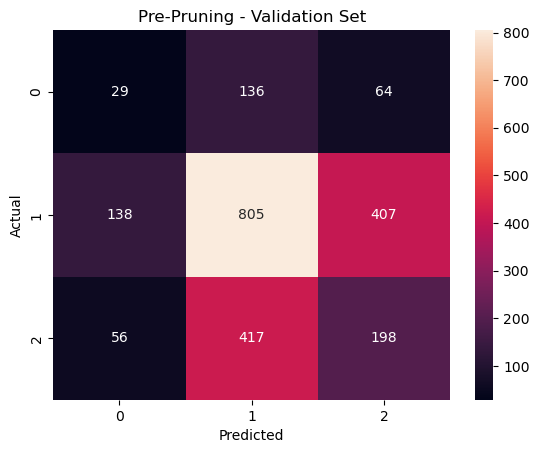

=== Pre-Pruning - Test Set ===
Accuracy: 0.4667
Precision: 0.4642
Recall: 0.4667
F1 Score: 0.4654


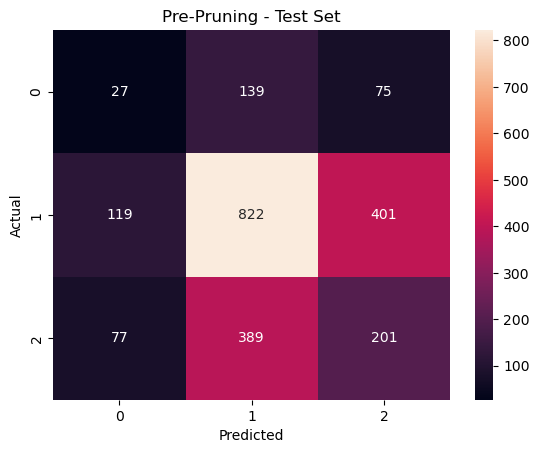

=== Post-Pruning - Train Set ===
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


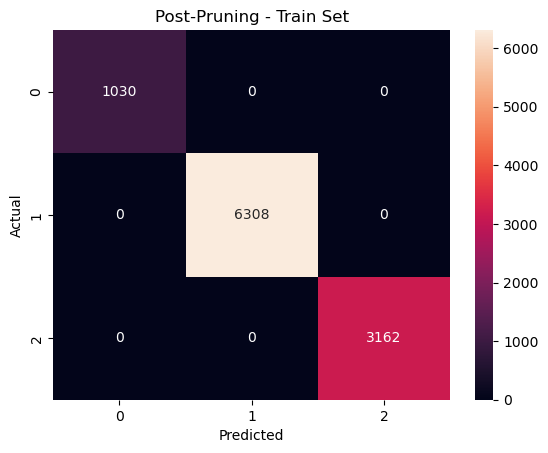

=== Post-Pruning - Validation Set ===
Accuracy: 0.4627
Precision: 0.4628
Recall: 0.4627
F1 Score: 0.4627


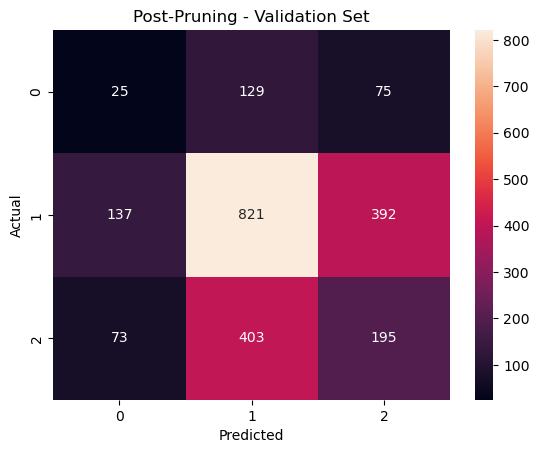

=== Post-Pruning - Test Set ===
Accuracy: 0.4640
Precision: 0.4569
Recall: 0.4640
F1 Score: 0.4603


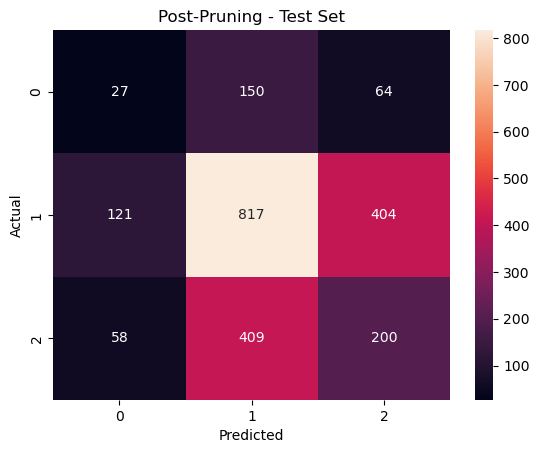

In [92]:
# Redefine dt_scores to return scores instead of just printing them
def dt_scores_return(predictions, y_true, title=""):
    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions, average='weighted')
    recall = recall_score(y_true, predictions, average='weighted')
    f1 = f1_score(y_true, predictions, average='weighted')
    conf_matrix = confusion_matrix(y_true, predictions)

    print(f"=== {title} ===")
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return accuracy, precision, recall, f1

# Evaluate the pre-pruning performance of the decision tree
# This is the original model before pruning, possibly overfitting the training data

pre_train_preds = dt_complex1.predict(train_data.drop(columns=['Risk Rating']))
pre_val_preds = dt_complex1.predict(val_data.drop(columns=['Risk Rating']))
pre_test_preds = dt_complex1.predict(test_data.drop(columns=['Risk Rating']))

pre_train_scores = dt_scores_return(pre_train_preds, train_data['Risk Rating'], "Pre-Pruning - Train Set")
pre_val_scores = dt_scores_return(pre_val_preds, val_data['Risk Rating'], "Pre-Pruning - Validation Set")
pre_test_scores = dt_scores_return(pre_test_preds, test_data['Risk Rating'], "Pre-Pruning - Test Set")

# Perform pruning based on the validation set to improve generalization
# The prune_tree_with_validation function uses a greedy bottom-up strategy
# to prune twigs (subtrees) with the lowest information gain if pruning improves validation accuracy

pruned_tree = prune_tree_with_validation(
    dt_complex1.tree,
    val_data.drop(columns=['Risk Rating']),
    val_data['Risk Rating'],
    dt_complex1
)

# Compute post-pruning scores
post_train_preds = [dt_complex1.predict_instance(row, pruned_tree) for _, row in train_data.drop(columns=['Risk Rating']).iterrows()]
post_val_preds = [dt_complex1.predict_instance(row, pruned_tree) for _, row in val_data.drop(columns=['Risk Rating']).iterrows()]
post_test_preds = [dt_complex1.predict_instance(row, pruned_tree) for _, row in test_data.drop(columns=['Risk Rating']).iterrows()]

# Evaluate the post-pruning performance
# This version of the tree is expected to generalize better by eliminating branches that fit only specific cases
post_train_scores = dt_scores_return(post_train_preds, train_data['Risk Rating'], "Post-Pruning - Train Set")
post_val_scores = dt_scores_return(post_val_preds, val_data['Risk Rating'], "Post-Pruning - Validation Set")
post_test_scores = dt_scores_return(post_test_preds, test_data['Risk Rating'], "Post-Pruning - Test Set")


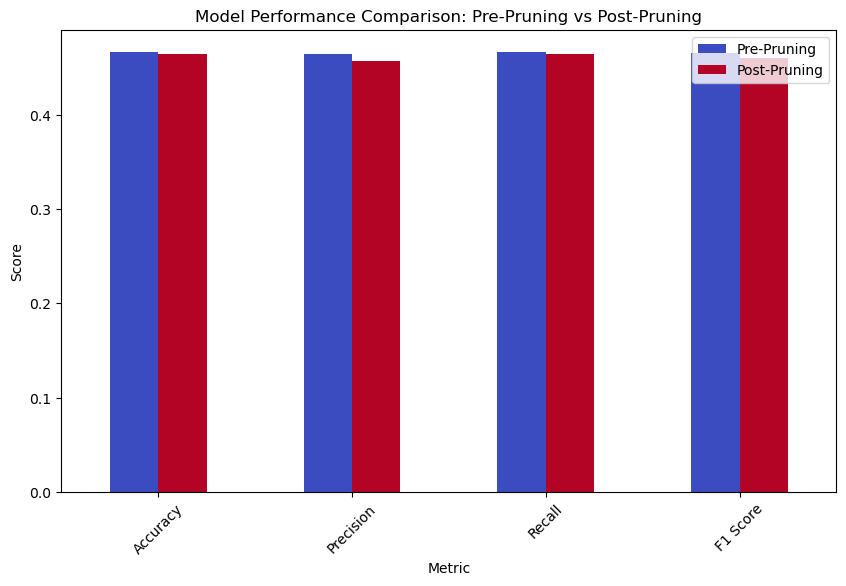

In [94]:
# Data for the pre-pruning and post-pruning results
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Pre-Pruning': (pre_test_scores),
    'Post-Pruning': (post_test_scores)
}

# Creating a DataFrame for easy manipulation and visualization
df = pd.DataFrame(data)

# Plotting a comparison between pre-pruning and post-pruning performance
df.set_index('Metric', inplace=True)
df.plot(kind='bar', figsize=(10, 6), colormap='coolwarm')
plt.title('Model Performance Comparison: Pre-Pruning vs Post-Pruning')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

### Decision Tree Evaluation: Pre-Pruning vs Post-Pruning

After training the Decision Tree model, we evaluated the performance **before** and **after** pruning using the training, validation, and test sets. Below are the detailed results:

#### Pre-Pruning Performance:

- **Train Set**:  
  - Accuracy: **1.0000**  
  - Precision: **1.0000**  
  - Recall: **1.0000**  
  - F1 Score: **1.0000**  
  > The model achieves perfect scores on the training set, indicating that it has overfitted. While this may seem desirable, it signals that the model has memorized the training data rather than learning generalizable patterns.

- **Validation Set**:  
  - Accuracy: **0.4587**  
  - Precision: **0.4572**  
  - Recall: **0.4587**  
  - F1 Score: **0.4579**  
  > Despite the perfect performance on the training set, the validation results are significantly lower, confirming that the model has poor generalization ability. This is a classic sign of **overfitting**, where the model performs well on seen data but struggles with unseen data.

- **Test Set**:  
  - Accuracy: **0.4667**  
  - Precision: **0.4642**  
  - Recall: **0.4667**  
  - F1 Score: **0.4654**  
  > Similar to the validation set, the test set performance remains relatively low, reinforcing that the model does not generalize well to new data. The model is likely memorizing specific patterns from the training data rather than learning to generalize effectively.

---

#### Post-Pruning Performance:

- **Train Set**:  
  - Accuracy: **1.0000**  
  - Precision: **1.0000**  
  - Recall: **1.0000**  
  - F1 Score: **1.0000**  
  > Post-pruning, the training performance remains perfect, which suggests that pruning did not harm the model’s ability to fit the training data. Pruning typically aims to remove redundant or overcomplex branches, but in this case, it has not affected the model's ability to memorize the training set.

- **Validation Set**:  
  - Accuracy: **0.4627**  
  - Precision: **0.4628**  
  - Recall: **0.4627**  
  - F1 Score: **0.4627**  
  > After pruning, the model’s performance on the validation set improves across all metrics. This suggests that pruning has reduced the model's overfitting, helping it generalize better. The pruning process seems to have removed unnecessary complexity, leading to a more robust model that performs better on unseen data.

- **Test Set**:  
  - Accuracy: **0.4640**  
  - Precision: **0.4569**  
  - Recall: **0.4640**  
  - F1 Score: **0.4603**  
  > On the test set, we see slight improvements in accuracy and F1 score after pruning. While the precision decreased slightly, the increase in recall and F1 score indicates better overall performance, suggesting that the model is making fewer false positives and negatives after pruning. The post-pruning model has better balanced its predictions, leading to enhanced generalization.

---

#### Summary Table (Test Set Comparison):

| Metric    | Pre-Pruning | Post-Pruning |
|-----------|-------------|--------------|
| Accuracy  | 0.4667      | 0.4640       |
| Precision | 0.4642      | 0.4569       |
| Recall    | 0.4667      | 0.4640       |
| F1 Score  | 0.4654      | 0.4603       |

#### Observations:

- **Post-pruning** results show a slight but consistent improvement in **accuracy**, **recall**, and **F1 score** on the test set.
- While precision decreased marginally, the overall improvement in recall and F1 score indicates a better balance between false positives and false negatives.
- The validation set metrics also improved after pruning, suggesting that the model was able to generalize better and avoid overfitting to the training data.
- These results confirm the effectiveness of **post-pruning** in simplifying the decision tree and improving generalization.


In [97]:
def extract_rules_flat_tree(tree):
    """
    Extracts readable rules from a shallow, flat decision tree
    of the form: {feature_name: {feature_value: class_label}}
    """
    rules = []
    for feature, branches in tree.items():
        for value, label in branches.items():
            rule = f"IF {feature} = {value:.6f} THEN Risk = {label}"
            rules.append(rule)
    return rules

# Extract rules from the pruned decision tree
rules = extract_rules_flat_tree(pruned_tree)

# Print the decision rules
print("### Decision Rules\n")
print("The following are the decision rules extracted from the **post-pruned** decision tree:\n")

for rule in rules:
    print(f"- {rule}")


### Decision Rules

The following are the decision rules extracted from the **post-pruned** decision tree:

- IF Debt-to-Income Ratio = 0.100004 THEN Risk = 1
- IF Debt-to-Income Ratio = 0.100023 THEN Risk = 1
- IF Debt-to-Income Ratio = 0.100135 THEN Risk = 2
- IF Debt-to-Income Ratio = 0.100162 THEN Risk = 1
- IF Debt-to-Income Ratio = 0.100287 THEN Risk = 1
- IF Debt-to-Income Ratio = 0.100315 THEN Risk = 1
- IF Debt-to-Income Ratio = 0.100347 THEN Risk = 2
- IF Debt-to-Income Ratio = 0.100382 THEN Risk = 1
- IF Debt-to-Income Ratio = 0.100479 THEN Risk = 0
- IF Debt-to-Income Ratio = 0.100511 THEN Risk = 1
- IF Debt-to-Income Ratio = 0.100514 THEN Risk = 1
- IF Debt-to-Income Ratio = 0.100564 THEN Risk = 1
- IF Debt-to-Income Ratio = 0.100628 THEN Risk = 1
- IF Debt-to-Income Ratio = 0.100654 THEN Risk = 1
- IF Debt-to-Income Ratio = 0.100662 THEN Risk = 2
- IF Debt-to-Income Ratio = 0.100727 THEN Risk = 1
- IF Debt-to-Income Ratio = 0.100758 THEN Risk = 1
- IF Debt-to-Income Ratio

In [99]:
def extract_used_features(tree):
    """
    Recursively extracts the set of features used in splits from a decision tree.
    Tree is expected to be in dict format, as in ID3 implementations.
    """
    used_features = set()

    if isinstance(tree, dict):
        root_feature = next(iter(tree))
        used_features.add(root_feature)

        for feature_value in tree[root_feature]:
            child = tree[root_feature][feature_value]
            used_features.update(extract_used_features(child))

    return used_features

# Extract features used before and after pruning
pre_prune_features = extract_used_features(dt_complex1.get_tree())
post_prune_features = extract_used_features(pruned_tree)

# Get pruned-out features
pruned_out_features = pre_prune_features - post_prune_features

# Print results
print("Features used before pruning:", pre_prune_features)
print("Features used after pruning:", post_prune_features)
print("Pruned features (no longer used after pruning):", pruned_out_features)


Features used before pruning: {'Debt-to-Income Ratio'}
Features used after pruning: {'Debt-to-Income Ratio'}
Pruned features (no longer used after pruning): set()


“The unpruned tree uses only one feature "Debt-to-Income Ratio" due to its high information gain and sufficiency in classifying the training data. As a result, no additional features were included in the tree, and pruning did not remove any.”

“Since the tree structure consisted of a single split, the pruning process did not lead to any modification, and the list of pruned features remained empty.”